# Darknet pattern analysis

## 1. Define session and libraries

In [1]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = "/opt/cloudera/parcels/Anaconda/bin/python"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-oracle-cloudera/jre"
os.environ["SPARK_HOME"] = "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
os.environ['PYSPARK_SUBMIT_ARGS'] = "pyspark-shell"

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark import sql
from pyspark.sql import Row
from pyspark.sql import SQLContext, HiveContext, DataFrameWriter
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, sum
from pyspark.sql import SparkSession
from datetime import datetime
import subprocess
import math
import time
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, col, udf
from operator import add
from functools import reduce
from pyspark.sql.functions import pandas_udf, PandasUDFType, split
import numpy as np
from scipy.stats import entropy
import pandas as pd
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
#pip install handyspark
from handyspark import *
import pickle


# described here https://medium.com/@achilleus/spark-session-10d0d66d1d24
print("starting")
spark = SparkSession.builder\
                    .appName("darknet_feature_extraction_without_hive")\
                    .master("yarn")\
                    .config("spark.submit.deployMode","client")\
                    .config("spark.executor.memory","20g")\
                    .config("spark.driver.memory","20g")\
                    .config('spark.sql.autoBroadcastJoinThreshold','-1')\
                    .config('spark.kryoserializer.buffer.max','1024m')\
                    .config('spark.driver.maxResultSize','0')\
                    .enableHiveSupport()\
                    .getOrCreate()

print("done with startup")

starting
done with startup


## 2. Data gathering and analysis
### 2.1 Anomaly time-intervals analysis
Datasets stored in HDFS are large and I came accross an java heap size issue many time. I separated the gathering in as many steps as possible and increased executor/driver memory in PYSPARK_SUBMIT_ARGS.
Resulting dataframe is too large(too many rows) for a single .csv. We plot the boxplots of anomaly time intervals by HandySpark which gives us ability to plot directly from Spark dataframes:

https://github.com/dvgodoy/handyspark

HandySpark does not support rotation of labels. Defining subplot in boxplot with "ax=ax" inside boxplot resulted in errors and HandySaprk adds name of the column to x labels. I changed the anomaly names to their abbreviations to make the plot readable.
Stratify in HandySpark does exactky the same as 'groupby' but according to authors its more effective.

In [33]:
time_int = '1day'
hdfs_root = '/user/mulinpav/NII_internship/datasets/darknet/time_interval_pattern_analysis/'
extracted_files_loc = '/user/mulinpav/NII_internship/datasets/darknet/*2019/extracted_' + time_int
hdfs_results_dir = hdfs_root + time_int
events_loc = hdfs_results_dir + '/events/*'


# extracted_files_loc_ls = subprocess.run(["hdfs", "dfs", "-ls", extracted_files_loc], stdout=subprocess.PIPE)
# extracted_files_loc_ls = str(extracted_files_loc_ls.stdout)
# extracted_files_loc_ls = extracted_files_loc_ls.split('\\n')
# extracted_files_loc_ls_filtered = [ x for x in extracted_files_loc_ls if "item" not in x ]
# num_files = len(extracted_files_loc_ls_filtered)

In [2]:
time_int = '1hour'
hdfs_root = '/user/mulinpav/NII_internship/datasets/darknet/time_interval_pattern_analysis/'
anomalies = ['net_scan_icmp_heavy_times', 'net_scan_icmp_light_times', 'net_scan_tcp_heavy_times',\
            'net_scan_tcp_light_times', 'net_scan_udp_heavy_times', 'net_scan_udp_light_times',\
            'one_flow_tcp_times', 'one_flow_udp_times', 'port_scan_tcp_heavy_times',\
            'port_scan_tcp_light_times', 'port_scan_udp_heavy_times', 'port_scan_udp_light_times',\
            'small_ping_times', 'small_syn_times', 'small_udp_times', 'events']

output_path = '/home/mulinpav/NII_internship/datasets/darknet/time_interval_pattern_analysis/1hour_distributed/'

for anomaly in anomalies:
    df = spark.read.csv(hdfs_root + time_int + '/' + anomaly + '/20190106000001_csv/*', header=True, inferSchema=True)
    df_pd = df.toPandas()
    df_pd.to_csv(output_path+anomaly+'/20190106000001.csv',index=False)

In [1]:
avg_list = list()
med_list = list()
whishi_list = list() 
whislo_list = list()
q1_list = list()
q3_list = list()

df_events = spark.read.csv(events_loc, header=True, inferSchema=True)
#total_sums = df_events.select(sum('port_scan_tcp_heavy'), sum('port_scan_tcp_light'), sum('port_scan_udp_heavy'), sum('port_scan_udp_light'), sum('net_scan_tcp_heavy'), sum('net_scan_tcp_light'), sum('net_scan_udp_heavy'), sum('net_scan_udp_light'), sum('net_scan_icmp_heavy'), sum('net_scan_icmp_light'), sum('one_flow_tcp'), sum('one_flow_udp'), sum('backscatter_tcp'), sum('backscatter_udp'), sum('backscatter_icmp'), sum('ip_fragment'), sum('small_syn'), sum('small_udp'), sum('small_ping'), sum('other_tcp'), sum('other_udp'), sum('other_icmp'), sum('other')).collect()
remaining = df_events.select('backscatter_tcp','backscatter_udp','backscatter_icmp','ip_fragment','other_tcp','other_udp','other_icmp','other','file_name')
df = remaining.groupBy('file_name').agg(F.sum('backscatter_tcp'), F.sum('backscatter_udp'), F.sum('backscatter_icmp'), F.sum('ip_fragment'), F.sum('other_tcp'), F.sum('other_udp'), F.sum('other_icmp'), F.sum('other'))

remaining_anomaly_list = ['sum(backscatter_tcp)', 'sum(backscatter_udp)', 'sum(backscatter_icmp)', 'sum(ip_fragment)', 'sum(other_tcp)', 'sum(other_udp)', 'sum(other_icmp)', 'sum(other)']
anomalies = ['backscatter_tcp','backscatter_udp','backscatter_icmp','ip_fragment','other_tcp','other_udp','other_icmp','other',]

for remaining_anomaly in remaining_anomaly_list:
    q123 = df.approxQuantile(remaining_anomaly,[0.25,0.5,0.75], 0)
    q1_list.append(q123[0])
    med_list.append(q123[1])
    q3_list.append(q123[2])
    whishi_list.append(df.agg({remaining_anomaly: "max"}).collect()[0]["max("+remaining_anomaly+")"])
    whislo_list.append(df.agg({remaining_anomaly: "min"}).collect()[0]["min("+remaining_anomaly+")"])
    avg_list.append(df.agg({remaining_anomaly: "avg"}).collect()[0]["avg("+remaining_anomaly+")"])

    boxplot_data = list()
    for i in range(len(med_list)):
        bdata_dict = {}
        bdata_event_time_dict = {}
        #bdata_dict['iqr'] = iqr_list[i]
        #bdata_dict['cilo'] = cilo_list[i]
        #bdata_dict['cihi'] = cihi_list[i]
        bdata_dict['mean'] = avg_list[i]    
        bdata_dict['whishi'] = whishi_list[i]
        bdata_dict['whislo'] = whislo_list[i]
        bdata_dict['fliers'] = []
        bdata_dict['q1'] = q1_list[i]
        bdata_dict['med'] = med_list[i]
        bdata_dict['q3'] = q3_list[i]
        bdata_dict['label'] = anomalies[i]
        boxplot_data.append(bdata_dict)
        
    f = open("darknet_pattern_analysis_boxplotstats_remaining_" + time_int + ".pkl","wb")
    pickle.dump(boxplot_data,f)
    f.close()

In [2]:
anomaly_count_list = list()
anomalies_list()
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.bxp.html
# required
avg_list = list()
med_list = list()
whishi_list = list() 
whislo_list = list()
q1_list = list()
q3_list = list()
avg_event_time_list = list()
med_event_time_list = list()
whishi_event_time_list = list() 
whislo_event_time_list = list()
q1_event_time_list = list()
q3_event_time_list = list()
# optional
# mean_list = list()
# cilo_list = list()
# cihi_list = list()
# fliers_list = list()
# iqr_list = list()


anomalies = ['net_scan_icmp_heavy_times', 'net_scan_icmp_light_times', 'net_scan_tcp_heavy_times',\
            'net_scan_tcp_light_times', 'net_scan_udp_heavy_times', 'net_scan_udp_light_times',\
            'one_flow_tcp_times', 'one_flow_udp_times', 'port_scan_tcp_heavy_times',\
            'port_scan_tcp_light_times', 'port_scan_udp_heavy_times', 'port_scan_udp_light_times',\
            'small_ping_times', 'small_syn_times', 'small_udp_times']

for anomaly in anomalies:
    print(anomaly)
    df = spark.read.csv(hdfs_root + time_int + '/' + anomaly + '/*', header=True, inferSchema=True)
    df_count = df.groupBy('file_name').agg(F.count("event_time_range").alias("count")).select("count")#.toPandas()
    # some time intervals may not have any anomaly - we need to add additional 0s to have correct distributions
    #if len(df_count) < num_files:
    #    df_count = df_count['count'].append(pd.Series(np.zeros(num_files-len(df_count))),ignore_index=True)
    anomaly_count_list.append(df.count())
    q123 = df_count.approxQuantile("count",[0.25,0.5,0.75], 0)
    q1_list.append(q123[0])
    med_list.append(q123[1])
    q3_list.append(q123[2])
    whishi_list.append(df_count.agg({"count": "max"}).collect()[0]["max(count)"])
    whislo_list.append(df_count.agg({"count": "min"}).collect()[0]["min(count)"])
    avg_list.append(df_count.agg({"count": "avg"}).collect()[0]["avg(count)"])
    #
    q123 = df.approxQuantile("event_time_range",[0.25,0.5,0.75], 0)
    q1_event_time_list.append(q123[0])
    med_event_time_list.append(q123[1])
    q3_event_time_list.append(q123[2])
    whishi_event_time_list.append(df.agg({"event_time_range": "max"}).collect()[0]["max(event_time_range)"])
    whislo_event_time_list.append(df.agg({"event_time_range": "min"}).collect()[0]["min(event_time_range)"])
    avg_event_time_list.append(df.agg({"event_time_range": "avg"}).collect()[0]["avg(event_time_range)"])    

anomaly_counts_data = {'anomaly': anomalies, 'count':anomaly_count_list} 
anomaly_counts_pd = pd.DataFrame(anomaly_counts_data) 
anomaly_counts_pd.to_csv('anomaly_counts_'+time_int+'.csv', index=False)

boxplot_data = list()
boxplot_event_time_data = list()
for i in range(len(med_list)):
    bdata_dict = {}
    bdata_event_time_dict = {}
    #bdata_dict['iqr'] = iqr_list[i]
    #bdata_dict['cilo'] = cilo_list[i]
    #bdata_dict['cihi'] = cihi_list[i]
    bdata_dict['mean'] = avg_list[i]    
    bdata_dict['whishi'] = whishi_list[i]
    bdata_dict['whislo'] = whislo_list[i]
    bdata_dict['fliers'] = []
    bdata_dict['q1'] = q1_list[i]
    bdata_dict['med'] = med_list[i]
    bdata_dict['q3'] = q3_list[i]
    bdata_dict['label'] = anomalies[i]
    bdata_event_time_dict['mean'] = avg_event_time_list[i]    
    bdata_event_time_dict['whishi'] = whishi_event_time_list[i]
    bdata_event_time_dict['whislo'] = whislo_event_time_list[i]
    bdata_event_time_dict['fliers'] = []
    bdata_event_time_dict['q1'] = q1_event_time_list[i]
    bdata_event_time_dict['med'] = med_event_time_list[i]
    bdata_event_time_dict['q3'] = q3_event_time_list[i]
    bdata_event_time_dict['label'] = anomalies[i] 
    boxplot_data.append(bdata_dict)
    boxplot_event_time_data.append(bdata_event_time_dict)
    
f = open("darknet_pattern_analysis_boxplotstats_" + time_int + ".pkl","wb")
pickle.dump(boxplot_data,f)
f.close()

f = open("darknet_pattern_analysis_boxplotstats_event_time_" + time_int + ".pkl","wb")
pickle.dump(boxplot_event_time_data,f)
f.close()

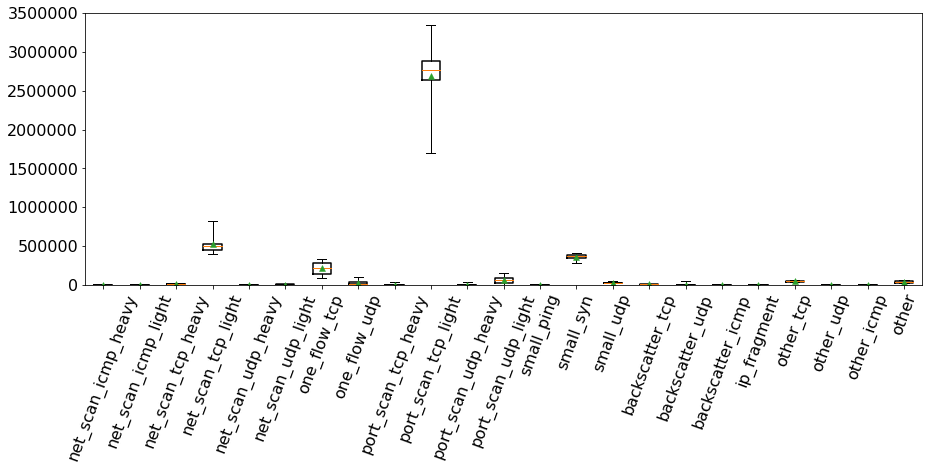

In [37]:
anomalies_bp = ['net_scan_icmp_heavy', 'net_scan_icmp_light', 'net_scan_tcp_heavy',\
               'net_scan_tcp_light', 'net_scan_udp_heavy', 'net_scan_udp_light',\
               'one_flow_tcp', 'one_flow_udp', 'port_scan_tcp_heavy',\
               'port_scan_tcp_light', 'port_scan_udp_heavy', 'port_scan_udp_light',\
               'small_ping', 'small_syn', 'small_udp',\
               'backscatter_tcp','backscatter_udp','backscatter_icmp','ip_fragment','other_tcp','other_udp','other_icmp','other']



time_int = '1day'
boxplot_data_remaining = pd.read_pickle("darknet_pattern_analysis_boxplotstats_remaining_" + time_int + ".pkl")
boxplot_data = pd.read_pickle("darknet_pattern_analysis_boxplotstats_" + time_int + ".pkl")
boxplot_data.extend(boxplot_data_remaining)
                                        
#boxplot_data = pd.read_pickle("darknet_pattern_analysis_boxplotstats_event_time_" + time_int + ".pkl")
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
bp = ax.bxp(boxplot_data,showmeans=True)
bp_xlabels = ax.set_xticklabels(anomalies_bp, rotation=70)
# max_seconds = 86400.0
# max_seconds = 3600.0
# bp_yticks = ax.set_yticks([0,0.25*max_seconds,0.5*max_seconds,0.75*max_seconds,max_seconds])
# bp_ylabels = ax.set_yticklabels(['0','0.25','0.5','0.75','1'])
# bp_ylim = ax.set_ylim([0,max_seconds])
# ax.set_ylabel('fraction of the time interval')
#ax.set_ylabel('count per time interval')
bp_ylim = ax.set_ylim([0,3500000])
#bp_ylim = ax.set_ylim([0,190000])
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(labelsize=16)
fig.savefig('darknet_'+time_int+'_counts.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)
#fig.savefig('darknet_'+time_int+'_event_time.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# PREV

#### 2.1.1 Results for 1 hour and 1 day

(<Figure size 1152x360 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f1d1c72c358>])

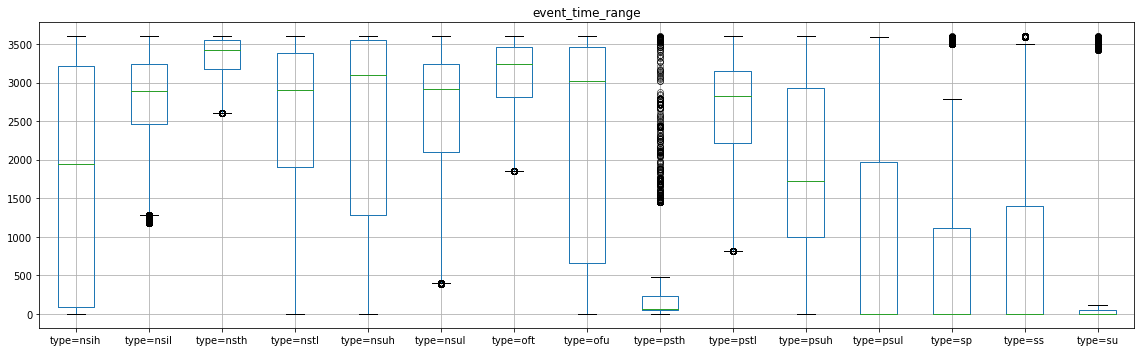

In [3]:
# event time range(1 hour)

(<Figure size 1152x360 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7fe4647dfb70>])

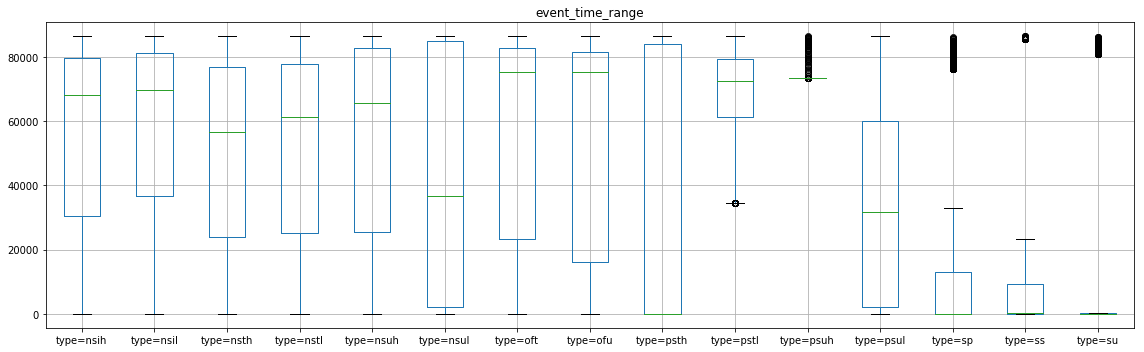

In [4]:
# event time range(1 day)

### 2.2 Events count analysis

We aggregate data per time-interval/split -> we can use pandas/matplotlib for analysis.

In [8]:
# sum anomalies per time window/split
events_df = spark.read.csv(events_loc, header=True, inferSchema=True)\
                      .drop('ip_src')\
                      .groupby(['file_name']).sum()
# drop file_name column so we can plot boxplots
events_pd = events_df.toPandas()
# filter outand rename columns that are not usefull for boxplots analysis
events_pd.drop(columns=['file_name','sum(file_name)'], inplace=True)
events_pd.columns = ['port scan tcp(heavy)','port scan tcp(light)', 'port scan udp(heavy)','port scan udp(light)', 'net scan tcp(heavy)','net scan tcp(light)', 'net scan udp(heavy)','net scan udp(light)', 'net scan icmp(heavy)','net scan icmp(light)', 'one flow tcp','one flow udp', 'backscatter tcp','backscatter udp', 'backscatter icmp','ip fragment', 'small syn', 'small udp','small ping', 'other tcp', 'other udp','other icmp', 'other']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
events_pd.boxplot(ax=ax,showfliers = False,rot=90)
ax.set_title('Distribution of anomalies per split(1min)')
ax.set_ylabel('# anomalies(log scale)')
ax.semilogy()

#### 2.2.1 Results for 1 hour and 1 day

[]

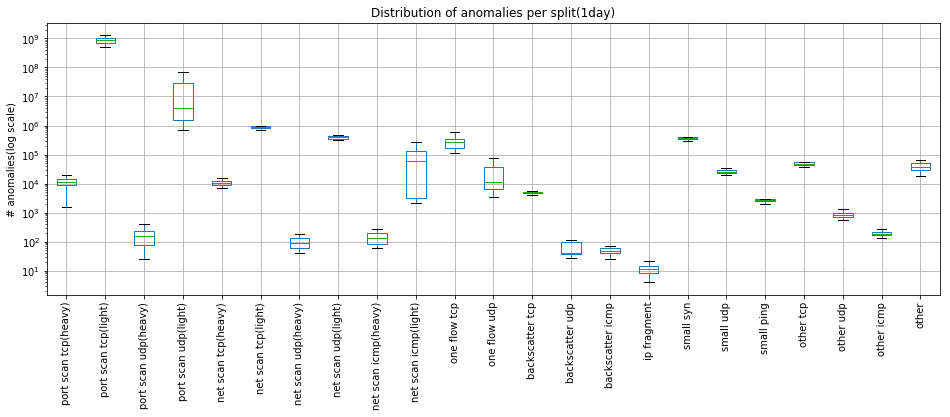

In [6]:
# Distribution of anomalies per split(1day)

[]

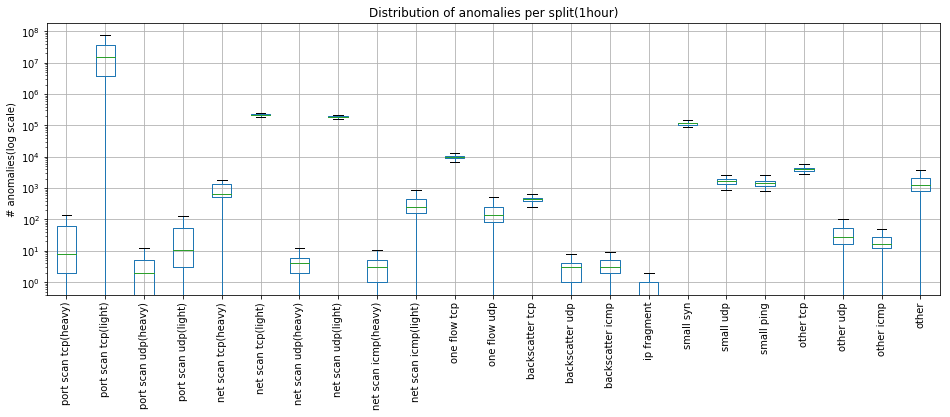

In [9]:
# Distribution of anomalies per split(1hour)